In [1]:
'''
这里的学习率策略是：

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

'''

import tempfile
import os

# 检查 tempfile 模块使用的临时文件目录
temp_dir = tempfile.gettempdir()
print("Updated temp directory:", temp_dir)

import sys
import importlib

new_path = '/data/mr423/project/agePrediction/'
if new_path not in sys.path:
    sys.path.insert(0, new_path)

# relaod the scgpt files
import scgpt
print("scgpt location: ", scgpt.__file__)
importlib.reload(scgpt)


import json
import copy
import os
from pathlib import Path
import shutil
import sys
import time
from typing import List, Tuple, Dict, Union, Optional
import warnings
import pandas as pd
# from . import asyn
import torch
from anndata import AnnData
import scanpy as sc
import seaborn as sns
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model import TransformerModel
from scgpt.tokenizer import tokenize_and_pad_batch

from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed

sc.set_figure_params(figsize=(6, 6))

os.environ["KMP_WARNINGS"] = "off"

os.environ["WANDB_MODE"]= "offline"

warnings.filterwarnings('ignore')

######################################################################
# Settings for wandb mentior
######################################################################

hyperparameter_defaults = dict(
    seed=0,
    do_train=True,
    load_model="/data/mr423/project/pre_trained_model/scGPT_human",
    n_bins=101,

    epochs=50,
    lr=0.0001,
    batch_size=128,

    layer_size=512, # 128
    nlayers=12,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    nhead=8,  # number of heads in nn.MultiheadAttention
    
    dropout=0.0,  # dropout probability

    use_fast_transformer=True,
    pre_norm=False,
    amp=True,  # Automatic Mixed Precision
    freeze = True, #freeze
)

run = wandb.init(
    config=hyperparameter_defaults,
    project="age_pred", # 修改修改修改修改修改修改修改修改修改修改修改修改修改修改修改修改
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

set_seed(config.seed)

######################################################################
# Settings for input and preprocessing
######################################################################

pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_value = "auto"  # for masked values, now it should always be auto

max_seq_len = 3001
n_bins = config.n_bins

# input/output representation
input_style = "binned"  # "normed_raw", "log1p", or "binned"                                    # decide the type of the input

input_emb_style = "category"  # "category" or "continuous" or "scaling"
cell_emb_style = "w-pool"  # "avg-pool" or "w-pool" or "cls"


######################################################################
# Settings for optimizer
######################################################################
lr = config.lr 
batch_size = config.batch_size
eval_batch_size = config.batch_size
epochs = config.epochs
early_stop = 10

######################################################################
# Settings for the model
######################################################################
use_fast_transformer = config.use_fast_transformer
fast_transformer_backend = "flash"  # "linear" or "flash"

embsize = config.layer_size  # embedding dimension
d_hid = config.layer_size  # dimension of the feedforward network in TransformerEncoder
nlayers = config.nlayers  # number of TransformerEncoderLayer in TransformerEncoder
nhead = config.nhead  # number of heads in nn.MultiheadAttention
dropout = config.dropout  # dropout probability

# %% validate settings
assert input_style in ["normed_raw", "log1p", "binned"]
assert input_emb_style in ["category", "continuous", "scaling"]

# if input_style == "binned":
#     if input_emb_style == "scaling":
#         raise ValueError("input_emb_style `scaling` is not supported for binned input.")
# elif input_style == "log1p" or input_style == "normed_raw":
#     if input_emb_style == "category":
#         raise ValueError(
#             "input_emb_style `category` is not supported for log1p or normed_raw input."
#         )

if input_emb_style == "category":
    mask_value = n_bins + 1
    pad_value = n_bins  # for padding gene expr values
    n_input_bins = n_bins + 2
else:
    mask_value = -1
    pad_value = -2
    n_input_bins = n_bins


######################################################################
# Settings for the running recording
######################################################################
dataset_name = 'biobank'
save_dir = Path(f"/data/mr423/project/code/save/{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)

print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")


######################################################################
# Data loading
######################################################################
# 修改修改修改修改修改修改修改修改修改修改修改修改修改修改修改修改
# 修改修改修改修改修改修改修改修改修改修改修改修改修改修改修改修改
adata = sc.read("/data/mr423/project/data/3-OLINK_data_train_withOutlier_all.h5ad")
adata_test = sc.read("/data/mr423/project/data/3-OLINK_data_test_withOutlier_all.h5ad")

# adata = sc.read("/data/mr423/project/data/split_data_for_re_train/3-OLINK_data_train_withOutlier_part2.h5ad")
# adata_test = sc.read("/data/mr423/project/data/split_data_for_re_train/3-OLINK_data_test_withOutlier_all.h5ad")

print(adata.shape)
print(adata_test.shape)

adata.obs["batch_id"]  = adata.obs["str_batch"] = "0"
adata_test.obs["batch_id"]  = adata_test.obs["str_batch"] = "1" 

adata.var.set_index(adata.var["gene_name"], inplace=True)
adata_test.var.set_index(adata.var["gene_name"], inplace=True)

data_is_raw = False
filter_gene_by_counts = False
adata_test_raw = adata_test.copy()
adata = adata.concatenate(adata_test, batch_key="str_batch")


# make the batch category column
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels

adata.var["gene_name"] = adata.var.index.tolist()


######################################################################
# The pre-trained model
######################################################################
if config.load_model is not None:
    model_dir = config.load_model
    # model_config_file = model_dir + "/args.json"

    model_file = "/data/mr423/project/code/save/biobank-Sep04-22-44/model.pt"
    vocab_file = "/data/mr423/project/code/save/biobank-Sep04-22-44/vocab.json"
    
    vocab = GeneVocab.from_file(vocab_file)
    shutil.copy(vocab_file, save_dir / "vocab.json")
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    # with open(model_config_file, "r") as f:
    #     model_configs = json.load(f)
    # logger.info(
    #     f"Resume model from {model_file}, the model args will override the "
    #     f"config {model_config_file}."
    # )
    # embsize = model_configs["embsize"]
    # nhead = model_configs["nheads"]
    # d_hid = model_configs["d_hid"]
    # nlayers = model_configs["nlayers"]
    # n_layers_cls = model_configs["n_layers_cls"]

    # print("\n**** parameters from the pre-trained model ****")
    # print(f'layer_size = embsize: {model_configs["embsize"]} = d_hid: {model_configs["d_hid"]}, n_layers: {model_configs["nlayers"]}, nhead: {model_configs["nheads"]}')
    # print("**** parameters from the pre-trained model ****\n")

    print("**** actual model parameters ****")
    print(f'layer_size = embsize: {embsize} = d_hid: {d_hid}, n_layers: {nlayers}, nhead: {nhead}')
    print("**** actual model parameters ****\n")

######################################################################
# set up the preprocessor, use the args to config the workflow
######################################################################
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=filter_gene_by_counts,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=3000,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)


adata_test = adata[adata.obs["str_batch"] == "1"]
adata = adata[adata.obs["str_batch"] == "0"]

# preprocessor(adata, batch_key=None)
preprocessor(adata_test, batch_key=None)


######################################################################
# Split the data to train and test
######################################################################
input_layer_key = {  # the values of this map coorespond to the keys in preprocessing
    "normed_raw": "X_normed",
    "log1p": "X_normed",
    "binned": "X_binned",
}[input_style]

print("input_layer_key: ", input_layer_key)

genes = adata.var["gene_name"].tolist()

if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)


# dataset
class SeqDataset(Dataset):
    def __init__(self, data: Dict[str, torch.Tensor]):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}


# data_loader
def prepare_dataloader(
    data_pt: Dict[str, torch.Tensor],
    batch_size: int,
    shuffle: bool = False,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader



Updated temp directory: /data/mr423/tmp
scgpt location:  /data/mr423/project/code/agePrediction/scgpt/__init__.py


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'seed': 0, 'do_train': True, 'load_model': '/data/mr423/project/pre_trained_model/scGPT_human', 'n_bins': 101, 'epochs': 50, 'lr': 0.0001, 'batch_size': 128, 'layer_size': 512, 'nlayers': 12, 'nhead': 8, 'dropout': 0.0, 'use_fast_transformer': True, 'pre_norm': False, 'amp': True, 'freeze': True}
save to /data/mr423/project/code/save/biobank-Sep08-18-00
(37304, 2919)
(4145, 2919)
scGPT - INFO - match 2895/2919 genes in vocabulary of size 60697.
**** actual model parameters ****
layer_size = embsize: 512 = d_hid: 512, n_layers: 12, nhead: 8
**** actual model parameters ****

scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Binning data ...
input_layer_key:  X_binned


In [2]:

######################################################################
# Load the model
######################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of gene vocabulary

print("\n\n **** load model parameters ****")
print(f'lr = {lr}, batch_size = {batch_size}, epochs = {epochs}')
print(f'ntokens = {ntokens}, layer_size = embsize: {embsize} = d_hid: {d_hid}, n_layers: {nlayers}, nhead: {nhead}')
print("**** load model parameters ****\n")

model = TransformerModel(
    ntokens,    # size of gene vocabulary
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=3,
    n_cls=1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=False,
    do_dab=False,
    use_batch_labels=False,
    num_batch_labels=None,
    domain_spec_batchnorm=False,
    input_emb_style=input_emb_style,
    n_input_bins=n_input_bins,
    cell_emb_style=cell_emb_style,
    explicit_zero_prob=False,
    use_fast_transformer=use_fast_transformer,
    fast_transformer_backend=fast_transformer_backend,
    pre_norm=config.pre_norm,
)
print("-"*20)
print("-"*20)

# if config.load_model is not None:
try:
    model.load_state_dict(torch.load(model_file))
    logger.info(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    logger.info(f"Loading some model params from {model_file}")
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict
        .items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        logger.info(f"Loading params {k} with shape {v.shape}")
    
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

# for name, param in model.named_parameters():
#     print(f"name: {name}")

model.to(device)

# print(model)
wandb.watch(model)



 **** load model parameters ****
lr = 0.0001, batch_size = 128, epochs = 50
ntokens = 60697, layer_size = embsize: 512 = d_hid: 512, n_layers: 12, nhead: 8
**** load model parameters ****

--------------------
--------------------
scGPT - INFO - Loading all model params from /data/mr423/project/code/save/biobank-Sep04-22-44/model.pt


[]

In [3]:
######################################################################
# Loss function
######################################################################

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
scaler = torch.cuda.amp.GradScaler(enabled=True)


######################################################################
# Evaluate the model
######################################################################
def evaluate(model: nn.Module, loader: DataLoader, return_raw: bool = False) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_num = 0

    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            age = batch_data["age"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=None,
                    CLS=False, 
                    CCE=False,
                    MVC=False,
                    ECS=False,
                    do_sample=False,
                    #generative_training = False,
                )
                
                output_values = output_dict["reg_output"]
                output_values = output_values.squeeze()

                loss = criterion(output_values, age)

                total_loss += loss.item() * len(input_gene_ids)     
                total_num += len(input_gene_ids)
                
                # 保存预测值和真实值以计算其他评估指标
                all_preds.append(output_values.cpu())
                all_targets.append(age.cpu())

    # 将所有批次的预测值和真实值连接起来
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    # 定义评估指标函数
    mse = torch.mean((all_preds - all_targets) ** 2) # 计算 MSE
    mae = torch.mean(torch.abs(all_preds - all_targets)) # 计算 MAE    
    rmse = torch.sqrt(mse) # 计算 RMSE

    # 计算 R2
    ss_res = torch.sum((all_targets - all_preds) ** 2)
    ss_tot = torch.sum((all_targets - torch.mean(all_targets)) ** 2)
    r2 = 1 - ss_res / ss_tot
    
    mape = torch.mean(torch.abs((all_targets - all_preds) / all_targets)) * 100  # 计算 MAPE

    val_loss = total_loss / total_num

    wandb.log(
        {
            "valid/loss": val_loss,
            "valid/mse": mse,
            "valid/mae": mae,
            "valid/rmse": rmse,
            "valid/r2": r2,
            "valid/mape": mape,
            "valid/r2/mae": r2/mae,
            # "epoch": epoch,
        },
    )

    scheduler.step(val_loss)
    
    # logger.info("-" * 89)
    logger.info(
    f"| valid  | total_num {total_num} loss {val_loss:5.4f} | mse {mse:5.4f} | " 
    f" mae {mae:5.4f} | rmse {rmse:5.4f} | " 
    f" r2 {r2:5.4f} | mape {mape:5.4f}")
    logger.info("-" * 89)


    # return total_loss / total_num, mse, mae, rmse, r2, mape
    return total_loss / total_num

In [4]:
all_counts = (
    adata_test.layers[input_layer_key].A
    if issparse(adata_test.layers[input_layer_key])
    else adata_test.layers[input_layer_key]
)

# print(adata_test.layers[input_layer_key])

age = adata_test.obs["age"].tolist()
age = np.array(age)


tokenized_test = tokenize_and_pad_batch(
    all_counts,
    gene_ids,
    max_len=max_seq_len,
    vocab=vocab,
    pad_token=pad_token,
    pad_value=pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=False,
)

tensor_age_test = torch.from_numpy(age).float()


test_data_pt = {
    "gene_ids": tokenized_test["genes"],
    "values": tokenized_test["values"],
    "age": tensor_age_test,
}

test_loader = DataLoader(
    dataset=SeqDataset(test_data_pt),
    batch_size=eval_batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=min(len(os.sched_getaffinity(0)), eval_batch_size // 2),
    pin_memory=True,
    )

In [ ]:
######################################################################
# Test the model
######################################################################
def test(model: nn.Module):

    
    model.eval()
    total_loss = 0.0
    total_num = 0

    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_data in test_loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["values"].to(device)
            age = batch_data["age"].to(device)

            src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])
            with torch.cuda.amp.autocast(enabled=config.amp):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=None,
                    CLS=False, 
                    CCE=False,
                    MVC=False,
                    ECS=False,
                    do_sample=False,
                    #generative_training = False,
                )
                    
                output_values = output_dict["reg_output"]
                output_values = torch.round(output_values * 10) / 10
                output_values = output_values.squeeze()

                # print(len(output_dict['attention_weights_list']))



                age = torch.round(age * 10) / 10

                loss = criterion(output_values, age)

                total_loss += loss.item() * len(input_gene_ids)     
                total_num += len(input_gene_ids)
    
                # 保存预测值和真实值以计算其他评估指标
                all_preds.append(output_values.cpu())
                all_targets.append(age.cpu())
            

    # 将所有批次的预测值和真实值连接起来
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    # 定义评估指标函数
    mse = torch.mean((all_preds - all_targets) ** 2) # 计算 MSE
    mae = torch.mean(torch.abs(all_preds - all_targets)) # 计算 MAE    
    rmse = torch.sqrt(mse) # 计算 RMSE

    ss_res = torch.sum((all_targets - all_preds) ** 2)
    ss_tot = torch.sum((all_targets - torch.mean(all_targets)) ** 2)
    r2 = 1 - ss_res / ss_tot
    
    mape = torch.mean(torch.abs((all_targets - all_preds) / all_targets)) * 100  # 计算 MAPE

    logger.info("-" * 89)
    logger.info("-" * 89)
    logger.info(
    f"| Test  | total_num {total_num} | mse {mse:5.4f} | " 
    f" mae {mae:5.4f} | rmse {rmse:5.4f} | " 
    f" r2 {r2:5.4f} | mape {mape:5.4f}")
    logger.info("-" * 89)



In [ ]:
print("-" * 89)
print("start test")
test(model)

In [5]:
def smooth_grad(model, input_gene_ids, input_values, target_age, vocab, pad_token, noise_level=0.1, num_samples=50):

    model.eval()
    gradients = []

    input_gene_ids = input_gene_ids.to(device)
    input_values = input_values.to(device)
    target_age = target_age.to(device)

    # Mask for padding tokens
    src_key_padding_mask = input_gene_ids.eq(vocab[pad_token])

    for _ in range(num_samples):
        # 添加噪声并确保 `requires_grad=True`，以便在反向传播时计算梯度
        noisy_input_values = input_values + noise_level * torch.randn_like(input_values)
        noisy_input_values.requires_grad = True  # 确保启用梯度追踪

        with torch.cuda.amp.autocast(enabled=config.amp):
            output_dict = model(
                input_gene_ids,
                noisy_input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=None,
                CLS=False, 
                CCE=False,
                MVC=False,
                ECS=False,
                do_sample=False,
            )
            output_values = output_dict["reg_output"].squeeze()

            # 计算损失并进行反向传播
            loss = criterion(output_values, target_age)
            model.zero_grad()  # 清除之前的梯度
            loss.backward()  # 反向传播，计算梯度

            # 收集每个样本的梯度
            gradients.append(noisy_input_values.grad.cpu().numpy())

    # 平均多个样本的梯度
    avg_gradients = np.mean(gradients, axis=0)
    
    return avg_gradients


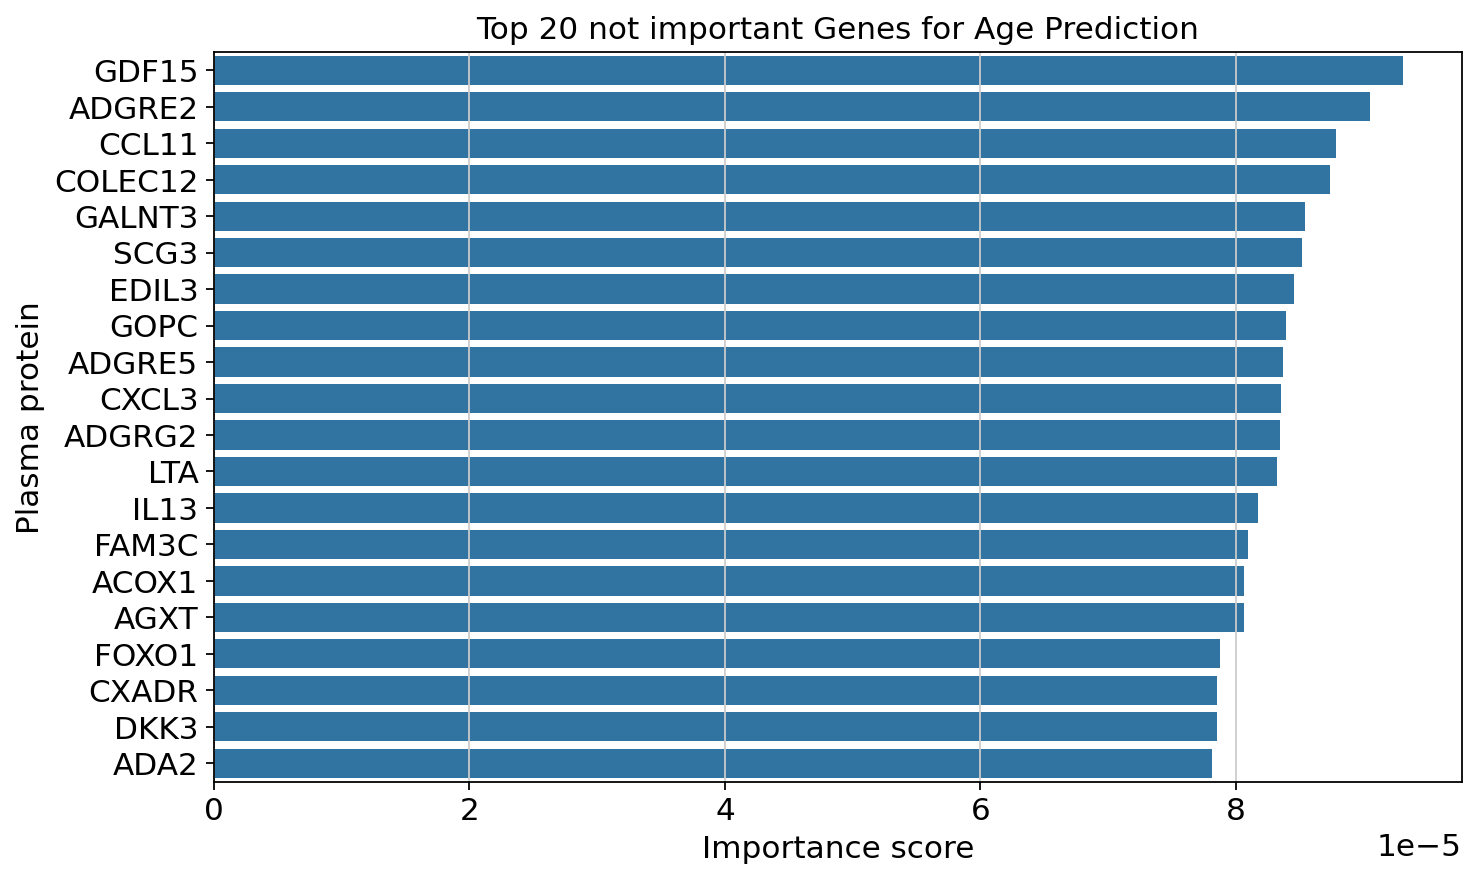

In [6]:
for batch_data in test_loader:
    input_gene_ids = batch_data["gene_ids"]
    input_values = batch_data["values"]
    target_age = batch_data["age"]
    
    # 使用 SmoothGrad 方法计算基因重要性
    avg_gradients = smooth_grad(
        model,
        input_gene_ids,
        input_values,
        target_age,
        vocab,
        pad_token=pad_token,
        noise_level=0.1,
        num_samples=50
    )
    
    # 可视化平均梯度值，显示哪些基因对预测最重要
    gene_names = adata.var["gene_name"].tolist()
    important_genes = np.mean(np.abs(avg_gradients), axis=0)  # 对不同样本取平均值
    
    sorted_indices = np.argsort(-important_genes)  # 由大到小排序
    top_genes = [gene_names[i] for i in sorted_indices[:20]]  # 获取最重要的前20个基因
    top_importances = important_genes[sorted_indices[:20]]
    
    # sorted_indices = np.argsort(important_genes)  # 对基因重要性升序排序
    # bottom_genes = [gene_names[i] for i in sorted_indices[:20]]  # 最不重要的前 20 个基因名称
    # bottom_importances = important_genes[sorted_indices[:20]]  # 对应的基因重要性值

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_importances, y=top_genes)
    plt.xlabel("Importance score")
    plt.ylabel("Plasma protein")
    plt.title("Top 20 not important Genes for Age Prediction")

    output_path = "./top_no_important_genes_smoothgrad.png"  # 你可以修改保存路径和文件名
    plt.savefig(output_path, dpi=300, bbox_inches="tight")  # dpi 300确保高质量保存，bbox_inches="tight" 去除空白边框

    plt.show()

    break  # 只处理一个批次